# Understanding PFENet

This notebook describes how to use the [Prior Guided Feature Enrichment Network (PFENet)][PFENet] for Few-Shot Segmentation applied to IVUS imaging. This and [Novel Data] should be executed in their repository, and suppose that the weights and checkpoints are downloaded.

This document just goes over the basics, refer to [Novel Data] for the training loop.

## Organization 

[PFENet]: https://github.com/dvlab-research/PFENet
[Novel Data]: ./Novel%20Data.ipynb

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from util import dataset
from util import transform

In [2]:
def render(img):
    '''Used to display a preprocessed image'''
    I = np.array(img)
    I = I - I.min((1,2), keepdims=1)
    I = I / I.max((1,2), keepdims=1)
    I = I.transpose((1,2, 0))
    return I
    
def overlay(img, mask, chan=1, weights=[0.5, 0.5]):
    '''Used to display a mask over an image'''
    T = np.zeros_like(img)
    T[..., chan] = mask
    return img * weights[0] + T * weights[1] 

In [3]:
from model.PFENet import PFENet
import torch
from torch import nn
SHOT = 1
def get_model(shot, checkpoint='split0_new.pth'):
    '''load a `shot`-shot model
    
    Parameters
    ==========
    shot : int
        number of support pairs per prediction
    checkpoint : str
        location of the trained model
    '''
    torch.cuda.empty_cache()
    model = PFENet(layers=50, classes=2, zoom_factor=8, \
        criterion=nn.CrossEntropyLoss(ignore_index=255), BatchNorm=nn.BatchNorm2d, \
        pretrained=True, shot=shot, ppm_scales=[60, 30, 15, 8])

    checkpoint = torch.load(checkpoint)
    model = torch.nn.DataParallel(model.cuda())
    model.load_state_dict(checkpoint['state_dict'])
    model.train(mode=False)
    print('Allocated:', torch.cuda.memory_allocated())
    return model
model = get_model(SHOT)

In [4]:
# Loading transformations as used in https://github.com/dvlab-research/PFENet
value_scale = 255
mean = [0.485, 0.456, 0.406]
mean = [item * value_scale for item in mean]
std = [0.229, 0.224, 0.225]
std = [item * value_scale for item in std]
val_transform = transform.Compose([
    transform.test_Resize(size=473),
    transform.ToTensor(),
    transform.Normalize(mean=mean, std=std),
]) 

sub_list:  [1]
sub_val_list:  [2]
Processing data...


100%|████████████████████████████████████████████████| 1449/1449 [00:02<00:00, 536.47it/s]

Checking image&label pair 0 list done! 


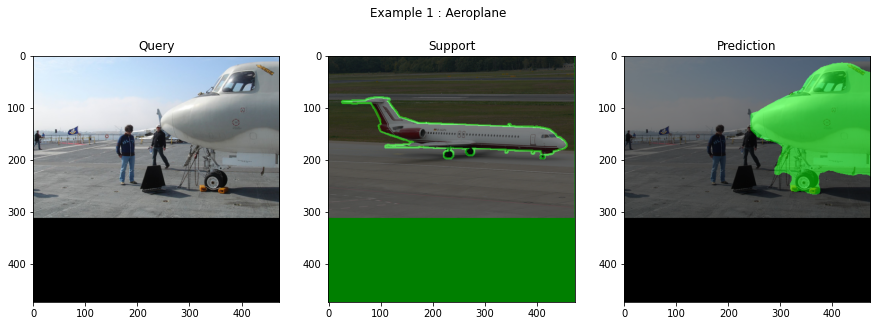

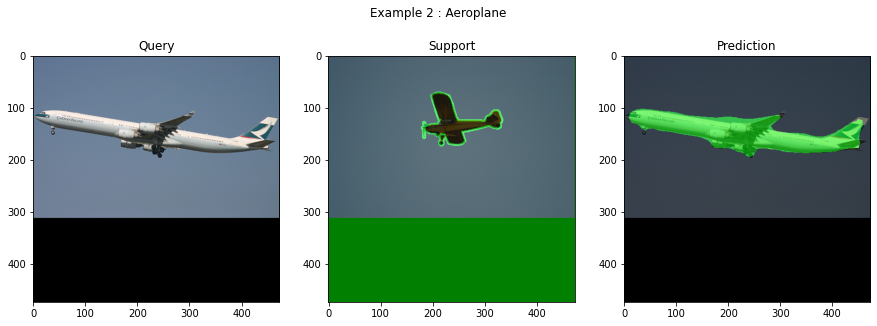

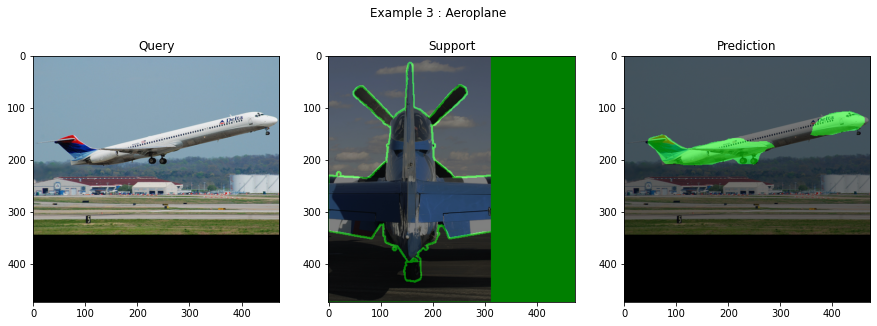

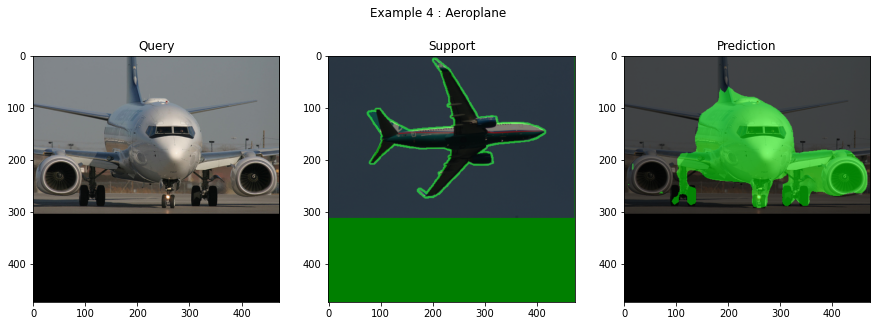

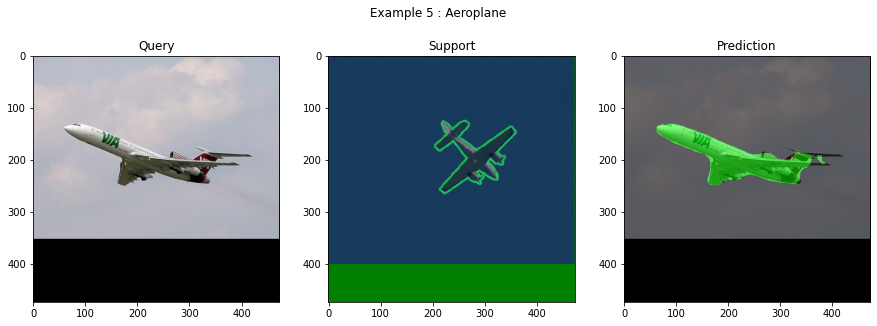

In [16]:
def example_1(n_examples=4):
    '''Show some images in the dataset'''
    from torch import nn
    import torch.nn.functional as F
    import torch
    from util.dataset import SemData
    
    torch.manual_seed(1)

    CLASS_NAMES = ['Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle', 
               'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable', 
               'Dog', 'Horse', 'Motorbike', 'Person', 'Pottedplant', 
               'Sheep', 'Sofa', 'Train', 'Tvmonitor',]




    ds = SemData(split=0, shot=SHOT, data_root='dataset/VOCdevkit/VOC2012/', \
                         data_list='lists/pascal/val.txt', transform=val_transform, mode='val')
    


    val_loader = torch.utils.data.DataLoader(ds, batch_size=1, shuffle=True, 
                                             num_workers=4, pin_memory=True, sampler=None)

    count = 0
    for img, target, s_input, s_mask, subcls, ori_label in val_loader:
        count += 1

        output = model(x=img, # y=target, 
                       s_x=s_input, s_y=s_mask)


        output = F.interpolate(output, size=target.size()[1:], mode='bilinear', align_corners=True) 
        output = output.max(1)[1].cpu().detach().numpy()

        I = render(img[0])
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        fig.suptitle(f'Example {count} : {", ".join(map(CLASS_NAMES.__getitem__, subcls))}')
        ax[0].set_title('Query')
        ax[0].imshow(render(img[0]))

        ax[1].set_title('Support')
        ax[1].imshow(overlay(render(s_input[0, 0]), s_mask[0, 0] / 255))

        ax[2].set_title('Prediction')
        ax[2].imshow(overlay(render(img[0]), output[0]))
        plt.show()

        if count > n_examples: break
example_1()

## Testing that the model actually works

We will test a 0-Shot test to see if there is actually influence of the support pair, or the train splits aren't correct and the model has seen the 'novel' classes.

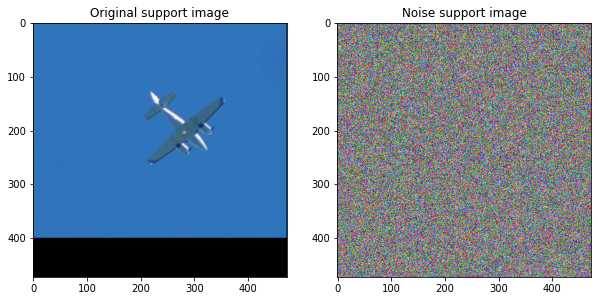

In [17]:
plt.figure(figsize=(10, 5))

ax = plt.subplot(121)
ax.set_title('Original support image')
plt.imshow(render(s_input[0, 0]))

s_input_noise = torch.tensor(np.random.random( size=s_input.shape).astype(np.float32))

ax = plt.subplot(122)
ax.set_title('Noise support image')
ax.imshow(render(s_input_noise[0, 0]))

plt.show()

In [18]:
output1 = model(x=img, # y=target, 
               s_x=s_input_noise, s_y=s_mask)
output_noise = output1.max(1)[1].cpu().detach().numpy()

output = model(x=img, # y=target, 
               s_x=s_input, s_y=s_mask)
output_ok = output.max(1)[1].cpu().detach().numpy()

In [19]:
output = output.cpu().detach()
output1 = output1.cpu().detach()

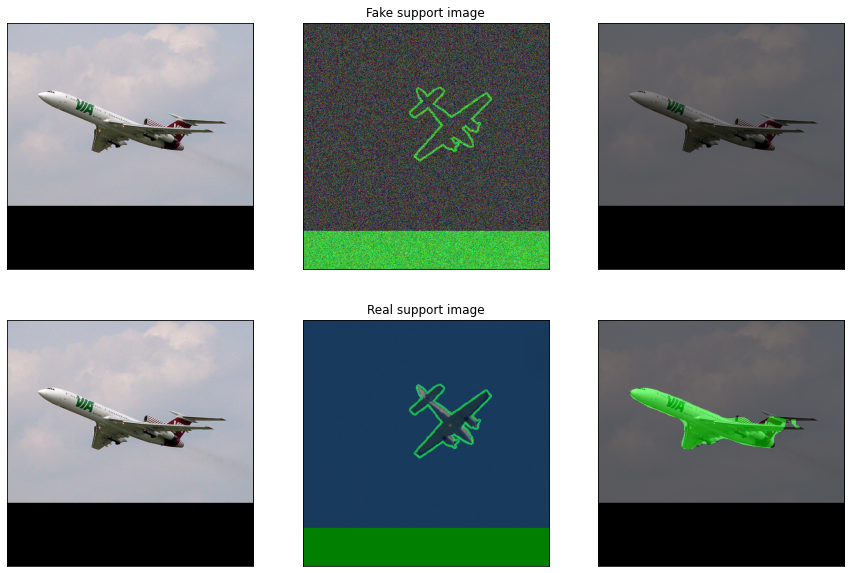

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

plt.set_cmap('jet')
for ax in axes.flatten():
    ax.tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)


axes[0, 1].set_title('Fake support image')
axes[0, 0].imshow( render(img[0]))
axes[0, 1].imshow(overlay(render(s_input_noise[0, 0]), s_mask / 255, weights=[0.5, 0.5]))
axes[0, 2].imshow(overlay(render(img[0]), output1[0].max(0).indices,  weights=[0.5, 0.5]))

axes[1, 1].set_title('Real support image')
axes[1, 0].imshow(render(img[0]))
axes[1, 1].imshow(overlay(render(s_input[0, 0]), s_mask / 255,  weights=[0.5, 0.5]))
axes[1, 2].imshow(overlay(render(img[0]), output[0].max(0).indices,  weights=[0.5, 0.5]))

fig.show()

From this we conclude it does actually work.

## Model applied to our problem

First we show and example using an unknown class (turtle) before we use IVUS imaging.

Notes:
- `turtle1.jpg` and `turtle2.png` are two different images of turtles. The images are **not** distributed with this.
- `mask.png` is a hand-drawn mask for `turtle2.png`.

Important considerations:
- a *mask* is a grayscale image with the background set to 0, the mask interior set to $k\in(0, 255)$ and an (optional) outline set to 255.

In [21]:
turtle = cv2.imread('turtle1.jpg', cv2.IMREAD_COLOR)
turtle = cv2.resize(turtle, (473, 473))
turtle = cv2.cvtColor(turtle, cv2.COLOR_BGR2RGB)  
turtle = np.float32(turtle)
#turtle = turtle / turtle.max(0, keepdims=1)
#turtle = turtle.astype(np.float32)

turtle2 = cv2.imread('turtle2.png', cv2.IMREAD_COLOR)
turtle2 = cv2.cvtColor(turtle2, cv2.COLOR_BGR2RGB)  
turtle2 = np.float32(turtle2)
#turtle2 = (turtle2 - turtle2.mean(0, keepdims=1)) / turtle2.std(0, keepdims=1)
#turtle2 = turtle2.astype(np.float32)
mask = cv2.imread('mask.png', cv2.IMREAD_GRAYSCALE)

turtle, _      = val_transform(turtle, mask)
turtle2, mask1 = val_transform(turtle2, mask)


In [22]:
def bucket(img, x, y, v):
    I = np.copy(img)
    h, w  = I.shape[:2]
    stack = [(x, y)]
    color = I[x, y]
    while stack:
        x, y = stack.pop()
        if I[x, y] != color:
            continue
            
        I[x, y] = v
        nb   = [(x-1, y-1), (x-1, y), (x-1, y+1),
                (  x, y-1),           (  x, y+1),
                (x+1, y-1), (x+1, y), (x+1, y+1)]
        nb   = [(x, y) for x, y in nb if (0 <= x < h) and (0 <= y < w)]
        
        stack.extend(nb)
    return I

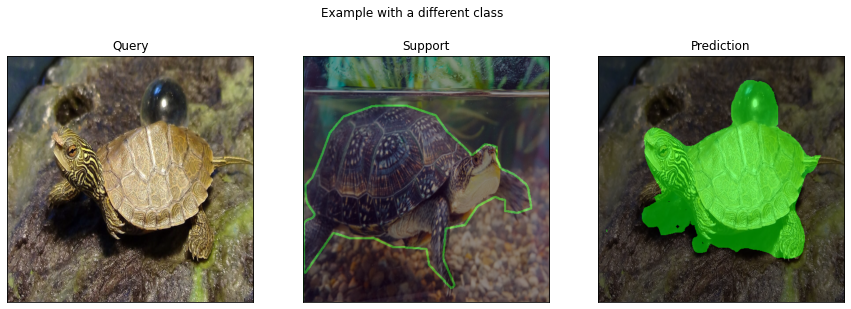

In [24]:
x   = turtle[None,...]
s_x = turtle2[None, None, ...]
s_y = mask1[None, None, ...]


output = model(x=x, s_x=s_x, s_y=s_y)
output = output.max(1)[1].cpu().detach().numpy()

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Example with a different class')

for a in ax:
    a.tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)
    
ax[0].imshow(render(turtle))
ax[0].set_title('Query')

ax[1].imshow(overlay(render(turtle2),  mask1 / 255, weights=[0.6, 0.4]))
ax[1].set_title('Support')


ax[2].imshow(overlay(render(x[0]), output))
ax[2].set_title('Prediction')

plt.show()

### Notes

1. The mask is a subset of pixels in the image bounded by a 255-value border.
2. The inside of the mask takes a value in (0, 255) and depict the class [note: only 1 is allowed]

### Ivus Data

In [5]:
def fetch_ivus_triplet(fi, fm, fl):
    '''Internal code that reads the images and draws 
    the mask as the PFENet expects
    
    Parameters
    ==========
    filenames for image, media and lumen
    
    Returns
    =======
    torch.Tensor with of image and two binary masks for
      lumen and media, respectively.
    '''
    with open(fl) as f:
        pts_lum = np.array([
            list(map(float, line.strip().split(',')))
            for line in f.readlines()
        ], np.int32)
        pts_lum = pts_lum.reshape((-1, 1, 2))

    with open(fm) as f:
        pts_med = np.array([
            list(map(float, line.strip().split(',')))
            for line in f.readlines()
        ], np.int32)
        pts_med = pts_med.reshape((-1, 1, 2))
    
    img = cv2.imread(fi, cv2.IMREAD_COLOR)
    img = img[..., [0, 0, 0]]
    

    # Inside of lumen
    lab_lumen = np.zeros(img.shape[:-1])
    cv2.fillPoly(lab_lumen, [pts_lum], 1)
    
    # Inside of media
    lab_media = np.zeros_like(lab_lumen)
    cv2.fillPoly(lab_media, [pts_med], 1)
    lab_media -= lab_lumen # remove points in lumen
    
    # Border of lumen
    lab_lumen = cv2.polylines(lab_lumen, [pts_lum], True, 255, 2)
    
    # Border of media
    lab_media = cv2.polylines(lab_media, [pts_lum], True, 255, 2)
    lab_media = cv2.polylines(lab_media, [pts_med], True, 255, 2)
    
    img = cv2.resize(img, (473, 473))
    lab_media = cv2.resize(lab_media, (473, 473))
    lab_lumen = cv2.resize(lab_lumen, (473, 473))
    lab_media = np.where((lab_media == 1) | (lab_media == 255), lab_media, 0)
    lab_lumen = np.where((lab_lumen == 1) | (lab_lumen == 255), lab_lumen, 0)
    
    # Use the model transforms
    _  , lab_media = val_transform(img, lab_media)
    img, lab_lumen = val_transform(img, lab_lumen)

    return img, lab_media, lab_lumen

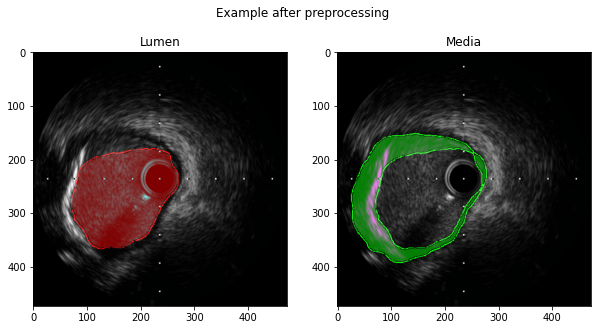

In [6]:
def demo():
    PATIENT = '01'
    FRAME   = '0001'

    img, med, lum = fetch_ivus_triplet(f'../dataset/Data_set_A/DCM/frame_{PATIENT}_{FRAME}_003.png',
                                       f'../dataset/Data_set_A/LABELS_obs2_v2/med_frame_{PATIENT}_{FRAME}_003.txt',
                                       f'../dataset/Data_set_A/LABELS_obs2_v2/lum_frame_{PATIENT}_{FRAME}_003.txt')

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle('Example after preprocessing')

    I = render(img)
    I[lum == 1, 0] = 0.5
    I[lum == 255, 0] = 1
    ax[0].set_title('Lumen')
    ax[0].imshow(I)
    I = render(img)
    I[med == 1, 1] = 0.5
    I[med == 255, 1] = 1
    ax[1].set_title('Media')
    ax[1].imshow(I)

    plt.show()
demo()

In [11]:
# Load dataset B
import os
import gc
from pathlib import Path
LOCATION = Path('../dataset/Data_set_A')

lum_files = sorted([f for f in os.listdir(LOCATION / 'LABELS_obs2_v2/') if 'lum' in f])
med_files = sorted([f for f in os.listdir(LOCATION / 'LABELS_obs2_v2/') if 'med' in f])

gc.collect()
torch.cuda.empty_cache() # just in case
images = []
medias = []
lumens = []
count = 0
for luf, mef in zip(lum_files, med_files):
    assert luf[3:] == mef[3:], (luf, mef)
    _, _, patient, frame, _ = luf.split('_')
    imf = LOCATION/ f'DCM/frame_{patient}_{frame}_003.png'
    luf = os.path.join(LOCATION / 'LABELS_obs2_v2/', luf)
    mef = os.path.join(LOCATION / 'LABELS_obs2_v2/', mef)
    imf, luf, mef = map(str, [imf, luf, mef])
    assert os.path.exists(imf), imf
    img, med, lum = fetch_ivus_triplet(imf, mef, luf)
    images.append(img)
    medias.append(med)
    lumens.append(lum)
images_train = torch.stack(images)
medias_train = torch.stack(medias)
medias_train = np.where(medias_train == 1, 2, medias_train)
lumens_train = torch.stack(lumens)

In [14]:
def store_images():
    '''This function will store the images and queries for validation or testing.'''
    from pathlib import Path
    data_root = Path('dataset/IVUS/')
    datalist = 'lists/ivus_lumens.txt'

    entries = []
    for i, (x, y) in enumerate(zip(images_train, lumens_train)):
        fx, fy = f'Queries/a-{str(i).zfill(4)}.png', f'Masks/a-lumen-{str(i).zfill(4)}.png'
        entry = f'{fx} {fy}\n'

        assert cv2.imwrite(str(data_root / fy), y.numpy())

        assert cv2.imwrite(str(data_root / fx), render(x.numpy()) * 255)
        entries.append(entry)
    with open(datalist, 'w') as f:
        f.writelines(entries)


    data_root = Path('dataset/IVUS/')
    vallist = 'lists/ivus_val.txt'


    entries = []
    for i, (x, y) in enumerate(zip(images_train, medias_train)):
        fx, fy =f'Queries/a-{str(i).zfill(4)}.png', f'Masks/a-media-{str(i).zfill(4)}.png'
        entry = f'{fx} {fy}\n'

        assert cv2.imwrite(str(data_root / fy), y)

        #assert cv2.imwrite(str(data_root / fx), render(x.numpy()) * 255)
        entries.append(entry)

    with open(vallist, 'w') as f:
        f.writelines(entries)


In [19]:
def jaccard_index(y_true, y_pred):
    ax = (1, 2)
    p = np.round(y_true)

    q = np.round(y_pred)

    intersection = np.sum(np.abs(p * q), ax)
    union = np.sum(p, ax) + np.sum(q, ax) - intersection
    return intersection / union

def hausdorff_distance(y_true, y_pred):
    from scipy.spatial.distance import directed_hausdorff
    r"""Calculate the Hausdorff distance between two sets. 

    Parameters
    ----------
    y_true : ndarray -- shape must be (N, M)
    y_pred : ndarray -- shape must be (N, S)

    Notes
    -----
    .. math:: \text{HD}(X, Y) = \max(\text{hd}(X, Y), \text{hd}(Y, X))
    .. math:: \text{hd}(X, Y) = \min_{x \in X} max{ y \in Y } |x-y|
    """
    P = np.stack(y_true.nonzero(), 1)
    Q = np.stack(y_pred.nonzero(), 1)
    d1 = directed_hausdorff(P, Q)[0]
    d2 = directed_hausdorff(Q, P)[0]
    return max(d1, d2)

def show_results(xi, yi, s_xi, s_yi, outi, title):
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    plt.set_cmap('jet')    
    for a in ax:
        a.tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)

    fig.suptitle(title)
    ax[0].set_title('Query')
    ax[0].imshow(render(xi))

    ax[1].set_title('Target')
    ax[1].imshow(overlay(render(xi), (yi == 1), 0,  weights=[0.7, 0.3]))


    ax[2].set_title('Support')
    ax[2].imshow(overlay(render(s_xi[0]), s_yi[0] == 1,  weights=[0.7, 0.3]))

    ax[3].set_title('Prediction')
    ax[3].imshow(outi.argmax(0))

    gt = np.float32(y[0] == 1)
    pr = np.float32(outi[1])

    jm = jaccard_index([gt], [pr])
    hd = hausdorff_distance(gt, pr) * (384 / 473 * 0.026) # mm per pixel

    s = f'Jaccard Index: {jm[0]:.2f}\nHausdorff distance: {hd:.2f}mm'
    ax[3].text(300, 450, s, bbox=dict(facecolor='#FFF', edgecolor='#AAA'))
    
    fig.show()

In [20]:
def show_results(xi, yi, s_xi, s_yi, outi, title):
    '''Display results of one-shot learning nicely'''
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    plt.set_cmap('jet')    
    for a in ax:
        a.tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)

    fig.suptitle(title)
    ax[0].set_title('Query')
    ax[0].imshow(render(xi))

    ax[1].set_title('Target')
    ax[1].imshow(overlay(render(xi), (yi == 1), 0,  weights=[0.7, 0.3]))


    ax[2].set_title('Support')
    ax[2].imshow(overlay(render(s_xi[0]), s_yi[0] == 1,  weights=[0.7, 0.3]))

    ax[3].set_title('Prediction')
    ax[3].imshow(outi.argmax(0))

    gt = np.float32(y[0] == 1)
    pr = np.float32(outi[1])

    jm = jaccard_index([gt], [pr])
    hd = hausdorff_distance(gt, pr) #* (384 / 473 * 0.026) # mm per pixel

    s = f'Jaccard Index: {jm[0]:.2f}\nHausdorff distance: {hd:.2f}mm'
    ax[3].text(300, 450, s, bbox=dict(facecolor='#FFF', edgecolor='#AAA'))
    
    fig.show()

**Hypothesis**: With 1-shot the model is learning to segment a 'dark round shape', for better improvement the model should probably learn to work better with US images.